# $t\bar{t}$ when minimizing $\Delta R_{jj}^{HC1}$

**Goal:** I was working through the `Vector-Ordered-HC` notebook, and something that Rafael told me is that my stripes really looked like a W-veto, so he suggested that I test this hypothesis by looking at the massplane before applying the $X_{wt}$ cut.

<img src="figures/vec_min_dRjj_h1/massplane_2b4b_preXwt.pdf">

As he suspected, this caused the stripes to go away, but I also thought that it was super interesting that we also have the $m_{HC2}$ peaking to much higher values.

I.e, the massplane now looks a lot more asymmetric, but I think this makes sense, because the invariant mass between two jets characterized by two 4-vectors $p_1$ and $p_2$ 

$$m^2 = (p_1 + p_2)^2 = p_1^2 + p_2^2 + 2 p_1 \cdot p_2 = m_1^2 + m_2^2 + 2 \left( E_1 E_2 - 2 \vec{p}_1 \cdot \vec{p}_1 \right) = m_1^2 + m_2^2 + 2 \left( E_1 E_2 - 2 |\vec{p}_1| | \vec{p}_1 | \cos (\theta) \right)$$

where $\theta$ is the opening angle between the jets.

The jet mass is around 10 GeV, but I think the interesting part about this study is that the new definition for the pairing gives us more of a handle on the physics of the 2b sample going into the background modelling.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import ROOT
from root_numpy import root2array, hist2array

import os
os.sys.path.append('../../hh4b-background-estimation/hep_ml')
from hep_ml import reweight
import pickle

os.sys.path.append('../code')
from plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Get the data

**Run over semi-leptonic $t\bar{t}$**
`resolved-recon --mc --lumi 24.3 -t triggers-2016.dat -o ttbar_semilep_topo16_min_Rjj_h1_vec.root --min_dRjj_lead --vectorOrdered --no-muon-iso ../public/hh4b/ttbar/user.wbalunas.HH4B.410470.ttbar.MC16a-2015-2016.AB21.2.61-MAR2019-Prod.topo_MiniNTuple.root/user.wbalunas.17415185._0000*.root`

**Run over all hadronic $t\bar{t}$**
`resolved-recon --mc --lumi 24.3 -t triggers-2016.dat -o ttbar_allhad_topo16_min_Rjj_h1_vec.root --min_dRjj_lead --vectorOrdered --no-muon-iso ../public/hh4b/ttbar/user.wbalunas.HH4B.410471.ttbar.MC16a-2015-2016.AB21.2.61-MAR2019-Prod.topo_MiniNTuple.root/user.wbalunas.17415188._00000*.root`

**Note:** I had to run with this `no-muon-iso` flag to avoid accessing this `muon_isIsolated_GradientLoose` branch that did not exist in these MAR2019 production Ntuples that I'm trying to run over right now.

In [11]:
basefileName = "../../hh4b-resolved-reconstruction/{}_topo16_min_Rjj_h1_vec.root"

In [4]:
ttbar_semilep = pd.DataFrame(root2array(basefileName.format("ttbar_semilep"),"fullmassplane"))
ttbar_allhad = pd.DataFrame(root2array(basefileName.format("ttbar_allhad"),"fullmassplane"))

In [5]:
ttbarText = "$\mathbf{ATLAS}$ Simulation Internal\n"
ttbarText += r"mc16a $t\bar{t}$ EMTopo jets"

config= "min $\Delta R_{jj}^{HC1}$: HC $p_T$ ordered"

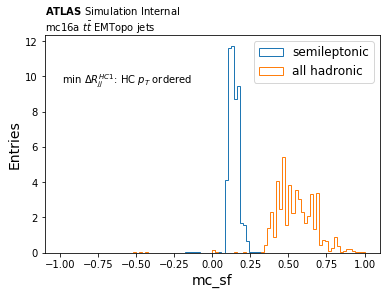

In [12]:
plt.hist(ttbar_semilep.mc_sf,100,(-1,1),'navy',histtype='step',label='semileptonic')
plt.hist(ttbar_allhad.mc_sf,100,(-1,1),'C1',histtype='step',label='all hadronic')

ax = plt.gca()
plt.text(0,1,ttbarText,ha='left',va='bottom',transform=ax.transAxes)
plt.text(0.05,.75,config,ha='left',va='bottom',transform=ax.transAxes)
plt.xlabel('mc_sf',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend(fontsize=12)

plt.savefig('figures/vec_min_dRjj_h1/ttbar_mc_sf.pdf')

plt.show()

Ok, so it doesn't look like they've saved weighted cutflows, so I think I need to calculate what fraction of the time we do and don't pass the $X_{wt}$ threshold.

In [6]:
filename = basefileName.format("ttbar_semilep")
semilep_preXwt = pd.concat([pd.DataFrame(root2array(filename,"hadtop")),
                            pd.DataFrame(root2array(filename,"top_multijet"))],
                           ignore_index=True)

filename = basefileName.format("ttbar_allhad")
allhad_preXwt = pd.concat([pd.DataFrame(root2array(filename,"hadtop")),
                            pd.DataFrame(root2array(filename,"top_multijet"))],
                           ignore_index=True)

In [7]:
for decay,df,df_preXwt in zip(['semilep','allhad'],
                              [ttbar_semilep,ttbar_allhad],
                              [semilep_preXwt,allhad_preXwt]):
   

    nend = np.sum(df.loc[df.ntag>=4,'mc_sf'])
    n_preXwt = np.sum(df_preXwt.loc[df_preXwt.ntag>=4,'mc_sf']) 
    print("{}: {:.0f}, {:.0f}, % kept = {:.2f}%".format(decay,nend,n_preXwt,100*nend/n_preXwt))
    
    # And now in the SR
    nend = np.sum(df.loc[(df.ntag>=4)&(df.kinematic_region==0),'mc_sf'])
    n_preXwt = np.sum(df_preXwt.loc[(df_preXwt.ntag>=4)&(df_preXwt.kinematic_region==0),'mc_sf']) 
    print("{} SR: {:.0f}, {:.0f}, % kept = {:.2f}%".format(decay,nend,n_preXwt,100*nend/n_preXwt))


semilep: 717, 1106, % kept = 64.84%
semilep SR: 29, 45, % kept = 65.13%
allhad: 1282, 2479, % kept = 51.70%
allhad SR: 105, 195, % kept = 53.61%


Ok, so this is good to know, now $X_{wt}$ keeps X % of the background.

I think the next order of business is to compare all of these histograms for the background reweighting that I derived with $$

Next, we want the massplanes for $t\bar{t}$ with and without $X_{wt}$

In [ ]:
for decay,df,df_preXwt in zip(['semilep','allhad'],
                              [ttbar_semilep,ttbar_allhad],
                              [semilep_preXwt,allhad_preXwt]):
    
    bkg_2bsameHC_massplanes(df, text=config,title=decay,
                            figDir='figures/vec_min_dRjj_h1/HC2b_data16',
                            tag=decay,chi2Option="WW")
    
    
    bkg_2bsameHC_massplanes(df_preXwt, text='No $X_{wt}$ cut',title=decay,
                            figDir='figures/vec_min_dRjj_h1/HC2b_data16',
                            tag=decay+'_preXwt',chi2Option="WW")
    

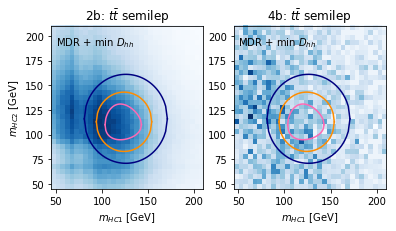

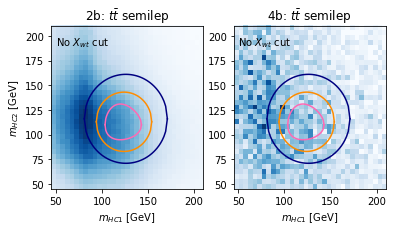

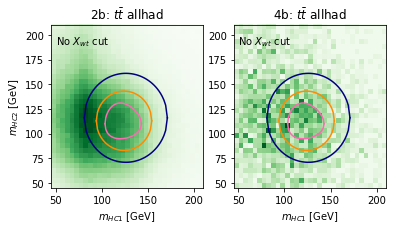

In [48]:
for decay,df,df_preXwt,cmap in zip(['semilep','allhad'],
                                   [ttbar_semilep,ttbar_allhad],
                                   [semilep_preXwt,allhad_preXwt],['Blues','Greens']):

    sig_bkg_massplanes(df,df, text=baseline,bkg_cmap=cmap,sig_cmap=cmap,
                       data_title=r'2b: $t\bar{t}$ '+decay,sig_title=r'4b: $t\bar{t}$ '+decay,
                       figDir='figures/vec_min_dRjj_h1/HC2b_data16',tag=decay)
    
    sig_bkg_massplanes(df_preXwt,df_preXwt, text='No $X_{wt}$ cut',bkg_cmap=cmap,sig_cmap=cmap,
                       data_title=r'2b: $t\bar{t}$ '+decay,sig_title=r'4b: $t\bar{t}$ '+decay,
                       figDir='figures/vec_min_dRjj_h1/HC2b_data16',tag=decay+'_preXwt')

2b
$\chi^2$/ndf = 57.03, KS $p$-val = 6.3e-20

2b same HC
$\chi^2$/ndf = 15.73, KS $p$-val = 9.5e-16



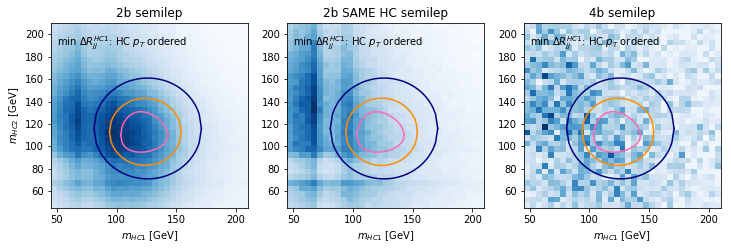

2b
$\chi^2$/ndf = 23.38, KS $p$-val = 7.8e-28

2b same HC
$\chi^2$/ndf = 8.05, KS $p$-val = 0



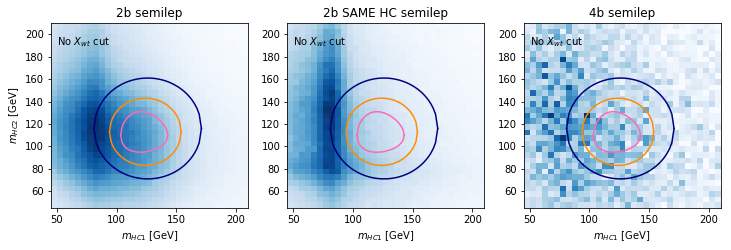

2b
$\chi^2$/ndf = 76.27, KS $p$-val = 3.7e-07

2b same HC
$\chi^2$/ndf = 22.68, KS $p$-val = 6e-25



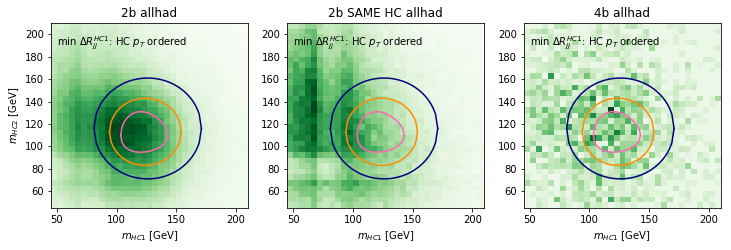

2b
$\chi^2$/ndf = 39.27, KS $p$-val = 4.2e-12

2b same HC
$\chi^2$/ndf = 13.59, KS $p$-val = 0



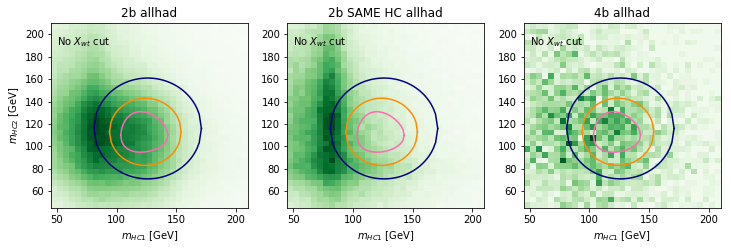

Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Warning in <TROOT::Append>: Replacing existing TH1: mp_2b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_2b_hc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_4b (Potential memory leak).
Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Warning in <TROOT::Append>: Replacing existing TH1: mp_2b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_2b_hc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_4b (Potential memory leak).
Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h2 with less than 10 effec

In [47]:
for decay,df,df_preXwt,cmap in zip(['semilep','allhad'],
                              [ttbar_semilep,ttbar_allhad],
                              [semilep_preXwt,allhad_preXwt],['Blues','Greens']):
    
    bkg_2bsameHC_massplanes(df, text=config,title=decay,cmap=cmap,
                            figDir='figures/vec_min_dRjj_h1/HC2b_data16',blinded=False,
                            tag=decay,chi2Option="WW")
    
    
    bkg_2bsameHC_massplanes(df_preXwt, text='No $X_{wt}$ cut',title=decay,cmap=cmap,
                            figDir='figures/vec_min_dRjj_h1/HC2b_data16',blinded=False,
                            tag=decay+'_preXwt',chi2Option="WW")
    

I think another thing that might be worthwile to do would be to look at how the BDT that we derived on data looks when we evaluate it on these $t\bar{t}$ samples, but this might take a bit more time.

## Comparison with the baseline analysis

Ok, so I think something else that I might want to check is the performance of the baseline analysis on the $t\bar{t}$ samples.

In [13]:
baselineFileName = "../../hh4b-resolved-reconstruction/{}_topo16_minMDR.root"

baseline= "MDR + min $D_{hh}$"

In [14]:
filename = baselineFileName.format("ttbar_semilep")
prev_ttbar_semilep = pd.DataFrame(root2array(filename,"fullmassplane"))
prev_semilep_preXwt = pd.concat([pd.DataFrame(root2array(filename,"hadtop")),
                            pd.DataFrame(root2array(filename,"top_multijet"))],
                           ignore_index=True)

filename = baselineFileName.format("ttbar_allhad")
prev_ttbar_allhad = pd.DataFrame(root2array(filename,"fullmassplane"))
prev_allhad_preXwt = pd.concat([pd.DataFrame(root2array(filename,"hadtop")),
                            pd.DataFrame(root2array(filename,"top_multijet"))],
                           ignore_index=True)

In [16]:
for decay,df,df_preXwt in zip(['semilep','allhad'],
                              [prev_ttbar_semilep,prev_ttbar_allhad],
                              [prev_semilep_preXwt,prev_allhad_preXwt]):
   

    nend = np.sum(df.loc[df.ntag>=4,'mc_sf'])
    n_preXwt = np.sum(df_preXwt.loc[df_preXwt.ntag>=4,'mc_sf']) 
    print("{}: {:.0f}, {:.0f}, % kept = {:.2f}%".format(decay,nend,n_preXwt,100*nend/n_preXwt))
    
    # And now in the SR
    nend = np.sum(df.loc[(df.ntag>=4)&(df.kinematic_region==0),'mc_sf'])
    n_preXwt = np.sum(df_preXwt.loc[(df_preXwt.ntag>=4)&(df_preXwt.kinematic_region==0),'mc_sf']) 
    print("{} SR: {:.0f}, {:.0f}, % kept = {:.2f}%".format(decay,nend,n_preXwt,100*nend/n_preXwt))
    
    
    
    #print("{}: {}, {}".format())
    

semilep: 488, 780, % kept = 62.51%
semilep SR: 58, 106, % kept = 54.30%
allhad: 1003, 1996, % kept = 50.25%
allhad SR: 184, 375, % kept = 48.94%


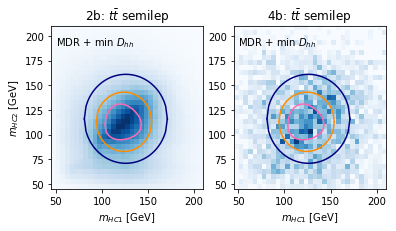

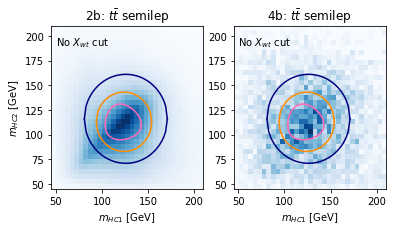

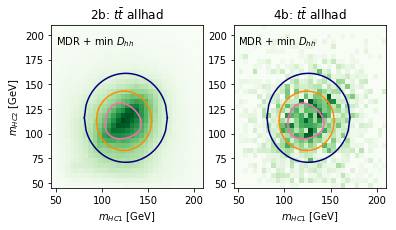

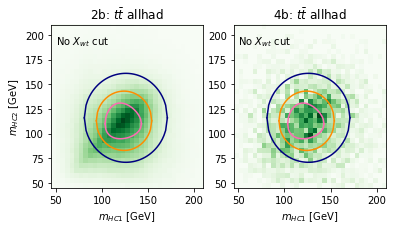

In [46]:
for decay,df,df_preXwt,cmap in zip(['semilep','allhad'],
                                   [prev_ttbar_semilep,prev_ttbar_allhad],
                                   [prev_semilep_preXwt,prev_allhad_preXwt],['Blues','Greens']):

    sig_bkg_massplanes(df,df, text=baseline,bkg_cmap=cmap,sig_cmap=cmap,
                       data_title=r'2b: $t\bar{t}$ '+decay,sig_title=r'4b: $t\bar{t}$ '+decay,
                       figDir='figures/HC2b_data16',tag=decay)
    
    
    sig_bkg_massplanes(df_preXwt,df_preXwt, text='No $X_{wt}$ cut',bkg_cmap=cmap,sig_cmap=cmap,
                       data_title=r'2b: $t\bar{t}$ '+decay,sig_title=r'4b: $t\bar{t}$ '+decay,
                       figDir='figures/HC2b_data16',tag=decay+'_preXwt')

2b
$\chi^2$/ndf = 62.40, KS $p$-val = 4.3e-21

2b same HC
$\chi^2$/ndf = 17.11, KS $p$-val = 2e-05



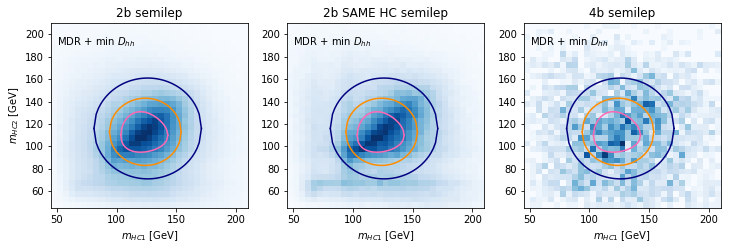

2b
$\chi^2$/ndf = 38.08, KS $p$-val = 1.5e-25

2b same HC
$\chi^2$/ndf = 12.34, KS $p$-val = 4.7e-22



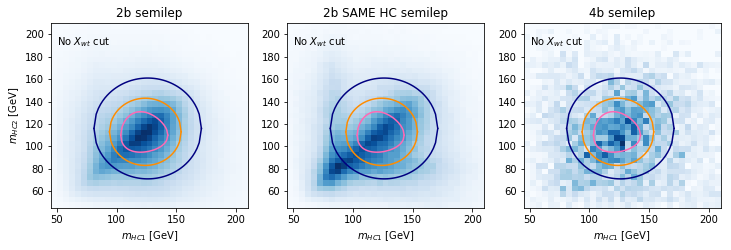

2b
$\chi^2$/ndf = 57.84, KS $p$-val = 1.1e-07

2b same HC
$\chi^2$/ndf = 15.28, KS $p$-val = 2.7e-05



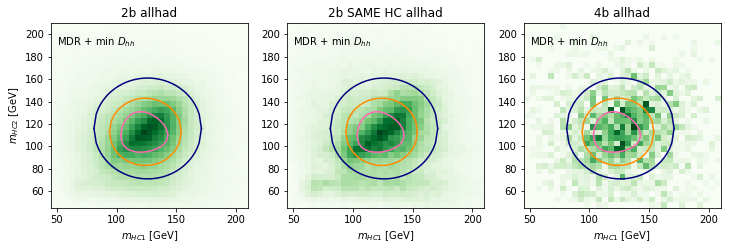

2b
$\chi^2$/ndf = 46.58, KS $p$-val = 1.6e-13

2b same HC
$\chi^2$/ndf = 13.45, KS $p$-val = 3.6e-28



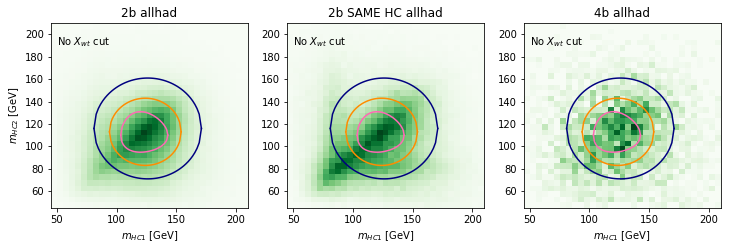

Warning in <TROOT::Append>: Replacing existing TH1: mp_2b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_2b_hc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_4b (Potential memory leak).
Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Warning in <TROOT::Append>: Replacing existing TH1: mp_2b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_2b_hc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mp_4b (Potential memory leak).
Info in <TH2D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2D::Chi2TestX>: There is a bin in h2 with less than 10 effec

In [40]:
for decay,df,df_preXwt,cmap in zip(['semilep','allhad'],
                                   [prev_ttbar_semilep,prev_ttbar_allhad],
                                   [prev_semilep_preXwt,prev_allhad_preXwt],['Blues','Greens']):
    
    bkg_2bsameHC_massplanes(df, text=baseline,title=decay,cmap=cmap,
                            figDir='figures/HC2b_data16',blinded=False,
                            tag=decay,chi2Option="WW")
    
    
    bkg_2bsameHC_massplanes(df_preXwt, text='No $X_{wt}$ cut',title=decay,cmap=cmap,
                            figDir='figures/HC2b_data16',blinded=False,
                            tag=decay+'_preXwt',chi2Option="WW")